In [1]:
import src.magfreqdistr as mfd
import src.datetimedistr as dtd
import src.spatprobdistr as spd
import src.depthdistr as dd
import src.aftershocks as shocks

import matplotlib.pyplot as plt
import numpy as np
import random as rand 

## Synthetic Earthquake Catalogue

The following are considered:

(1) Magnitude Frequency Distrbution <br>
(2) Random (Poissonian) temporal occurences of mainshocks <br>
(3) Spatially correlated epicenters <br>
(4) Hypocentral Depth <br>
(5) Foreshocks and Aftershocks <br>

### 1.  Magnitude Frequency Distrbution
The earthquakes are distributed according to Gutenberg-Richter (GR) law, which is given as below. <br>

log$_{10}$ [N(>=<i>M$_W$</i>)] = a-b <i>M$_W$</i> &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; &emsp; &emsp;(1)

where a and b are a-value and b-value, N is number of events, and M$_W$ refers to moment magnitude <i>Mw</i>.

        

In [2]:
# Lets setup the SIMULATION PARAMETERS -------------------------

# GR parameters
# b-value is typically equal to 1. a-value is equal to log10(N) when Mw = 0
bvalue = 1.0
# lets say we have 50 events with magnitude >= 5.0
avalue = mfd.calc_avalue(bvalue, 5.0, 80)

# minimum and maximum magnitude for simulated mainshocks
Mmin, Mmax = 5.0, 8.5

# total number of events
nevents=500

# date and time 
nyears = 40
min_year = 1960
max_year = min_year + nyears

# a rough spatial bounds - may not be restrictive
# * current implementation requires:
#    - rectangular bounds
#    - in degrees 
lat_min, lat_max = 10.0, 20.0
lon_min, lon_max = 20.0, 60.0

# output file
fileout = 'data/syncat1.npz'

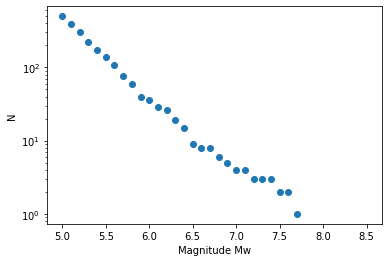

In [3]:
# get the magnitudes ---------------------------------------------
mags = mfd.sample_GRdistr(bvalue, avalue, Mmin, \
                          Mmax,nevents = nevents, \
                          mbin=0.1, rseed=20401)
mfd.distr_empirical(mags, Mmin, Mmax, doplot=True);


Figure. Magnitude frequency distribution

### 2. Random Temporal Occurences 

The mainshocks are assumed to be stationary, with random occurences. 

In [4]:
# get the date and time ------------------------------------------
event_dates = dtd.generate_random_datetimes(min_year, max_year, nevents)


### 3. Spatially correlated epicenters

Faults are not explicitely defined. A gausian random field is used. A better approach would use fault as well. However, the spatial random field allows a quick and easy implementation

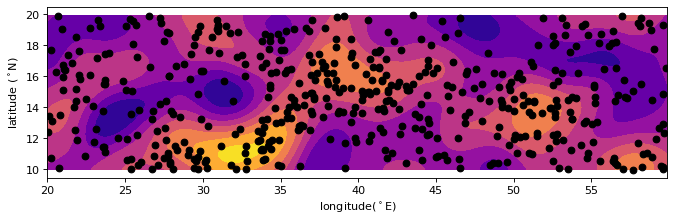

In [5]:
# get the epicenters --------------------------------------------
geobounds = (lon_min, lon_max, lat_min, lat_max)
lons, lats = spd.get_epicenters(geobounds, patch='high', \
                    nevents=len(mags), corr_dist = 20, sampdist = 0.1, doplot=True)


Figure. A Guassin random field is used to define the spatail probabilities of epicentral locations

### 4. Hypocentral depth distrubution

Shallow depths are considered with a corresponding depth bounds (mean depth 20 km). These depths are sampled from a lognormal distribution.

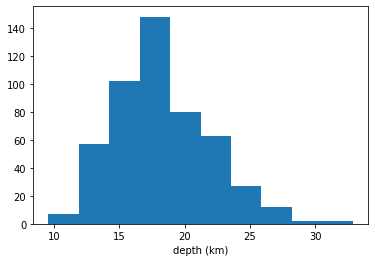

In [6]:
depths = dd.sample_depths(nevents, mean_depth = 18, isaftershock=False)
plt.hist(depths);
plt.xlabel('depth (km)');

Figure. Distrbution of depths sampled from a lognormal distribution

### 5. Foreshocks and Aftershocks

The following laws are considered:

(1) Omori's law <br>
 Omori–Utsu law is empirical observation that the rate of aftershocks following a large earthquake obeys the following relation: <br><br>
 λ(t, m) = χ [(t + c)^−p] <br>
 
(2)  Bath's law <br>

This empirical law states that the average difference in magnitude between a mainshock and its largest aftershock is 1.2,regardless of the mainshock magnitude.
<br>
<br>
Additionlly, the magniude-time-distance window of Gardner and Knopoff (1974) is applied:
<br><br>
log10(T) = 0.032*mag+2.7389, if mag>=6.5
<br><br>
log10(T) = 0.5409*mag-0.547, if mag<6.5
<br><br>
log10(L) = 0.1238*mag+0.983

This implementation consider eliptical bounds such that it is length=L and width = 0.667L. Also, these dimensions are exagrated 10 times. The spatial probabilties of the aftershocks are assummed to Gaussian with highest probability at the epicenter of the mainshock. Note that these considerations are ad hoc and primaily driven by the purpose to generating a synthetic dataset (rather than a consistent synthetic earthquake catalogue).

In [7]:
fmag, flon, flat, fdep, fdate, event_type  = [], [], [], [], [], []

# so we have mainshocks - mags,event_dates, lons, lats, depths
# for each mainshock, generate foreshocks and aftershocks
for M, lon, lat, dep, date in zip(mags, lons, lats, depths,event_dates):
    
    # we can also generate swarms by considering appropiate time window,
    # magnitude-rnage, spatila bounds, (short) correlation distance
    # instead of foreshocks and aftershocks
    
    M_fs, lon_fs, lat_fs, dep_fs, dates_fs = shocks.get_foreshocks(M, \
                                                        lon, lat, dep, date)
    if M_fs is not None:
        # put these events before the mainshock
        for m, ln ,lt, dp, dt in zip(M_fs, lon_fs, lat_fs, dep_fs, dates_fs):
            fmag.append(m)
            flon.append(ln)
            flat.append(lt)
            fdep.append(dp)
            fdate.append(dt)
            event_type.append(-1)
    # put the mainshock
    fmag.append(M)
    flon.append(lon)
    flat.append(lat)
    fdep.append(dep)
    fdate.append(date)
    event_type.append(0)
    # get afterschoks
    M_afs, lon_afs, lat_afs, dep_afs, dates_afs = shocks.get_aftershocks(M, \
                                                        lon, lat, dep, date)
    if M_afs is not None:
        # put these events after the mainshock
        for m, ln ,lt, dp, dt in zip(M_afs, lon_afs, lat_afs, dep_afs, dates_afs):
            fmag.append(m)
            flon.append(ln)
            flat.append(lt)
            fdep.append(dp)
            fdate.append(dt)
            event_type.append(1)

np.savez(fileout, mag=fmag, lon=flon, lat=flat, dep=fdep, date=fdate, event_type=event_type)

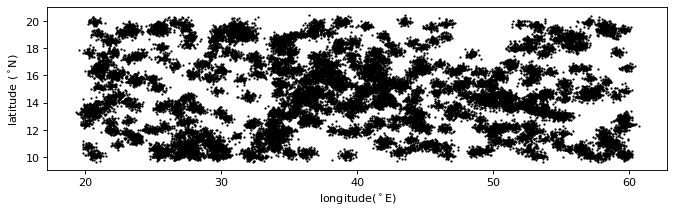

In [8]:
fig = plt.figure(figsize=(10, 6), dpi=80)
ax = fig.add_subplot(111)
#ax.contourf(mlon, mlat, spat_prob, cmap='plasma')
ax.plot(flon, flat, 'ko', markersize=1)
ax.set_aspect('equal')
ax.set_xlabel('longitude($^\circ$E)');
ax.set_ylabel('latitude ($^\circ$N)');